# Benchmark Graphs

This notebook loads `games.csv`, `guesses.csv`, and `generations.csv` from a benchmark run directory and generates a suite of graphs inline.

## Usage
1. Set `INPUT_DIR` below to your run folder (e.g. `benchmarking/results/run_YYYYMMDD_HHMMSS_tag`).
2. Run all cells.


In [30]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

INPUT_DIR = Path('results/run_20251212_204829_baseline') 
# Example:
# INPUT_DIR = Path('benchmarking/results/run_20251212_142233_baseline')

assert INPUT_DIR.exists(), f"INPUT_DIR does not exist: {INPUT_DIR}"
GAMES_CSV = INPUT_DIR / 'games.csv'
GUESSES_CSV = INPUT_DIR / 'guesses.csv'
GENERATIONS_CSV = INPUT_DIR / 'generations.csv'

print('Loading:')
print(' ', GAMES_CSV)
print(' ', GUESSES_CSV)
print(' ', GENERATIONS_CSV)

games = pd.read_csv(GAMES_CSV)
guesses = pd.read_csv(GUESSES_CSV)
gens = pd.read_csv(GENERATIONS_CSV)

display(games.head())
display(guesses.head())
display(gens.head())


Loading:
  results\run_20251212_204829_baseline\games.csv
  results\run_20251212_204829_baseline\guesses.csv
  results\run_20251212_204829_baseline\generations.csv


,run_id,game_id,seed,secret_expr,target_value,success,num_guesses,total_runtime_s,avg_runtime_per_guess_s,invalid_guess_count
0,run_20251212_204829_baseline,0,12345,99+2*1,101.0,1,3,10.450618,3.483539,0
1,run_20251212_204829_baseline,1,12346,12+2*8,28.0,1,6,21.576679,3.596113,0
2,run_20251212_204829_baseline,2,12347,53/5*0,0.0,0,6,22.410074,3.735012,0
3,run_20251212_204829_baseline,3,12348,2*72-9,135.0,0,6,20.056957,3.342826,0
4,run_20251212_204829_baseline,4,12349,31/1-4,27.0,1,3,10.342568,3.447523,0


,run_id,game_id,guess_index,guess_expr,guess_valid,guess_runtime_s,guess_fitness,feedback
0,run_20251212_204829_baseline,0,0,53+6*8,1,3.321398,4.776116,??????
1,run_20251212_204829_baseline,0,1,97+4*1,1,3.474489,11.591488,??????
2,run_20251212_204829_baseline,0,2,99+2*1,1,3.654677,17.834313,??????
3,run_20251212_204829_baseline,1,0,23+5-0,1,3.179738,4.776116,??????
4,run_20251212_204829_baseline,1,1,28+0*9,1,3.527960,-8.067657,??????


,run_id,game_id,guess_index,generation_index,gen_runtime_s,fitness_mean,fitness_max,fitness_min,fitness_std
0,run_20251212_204829_baseline,0,0,0,0.073218,-20.905924,4.776116,-22.316353,2.157439
1,run_20251212_204829_baseline,0,0,1,0.087460,-20.610504,4.776116,-22.316353,2.658175
2,run_20251212_204829_baseline,0,0,2,0.078275,-20.190894,4.776116,-22.316353,4.007498
3,run_20251212_204829_baseline,0,0,3,0.089456,-19.630188,4.776116,-22.316353,5.404977
4,run_20251212_204829_baseline,0,0,4,0.086852,-19.413713,4.776116,-22.316353,5.943570


In [31]:
def corr_pair(df: pd.DataFrame, x: str, y: str) -> float:
    a = pd.to_numeric(df[x], errors='coerce')
    b = pd.to_numeric(df[y], errors='coerce')
    m = a.notna() & b.notna()
    if m.sum() < 3:
        return float('nan')
    return float(np.corrcoef(a[m], b[m])[0, 1])

def quantiles(series: pd.Series):
    s = pd.to_numeric(series, errors='coerce').dropna()
    if len(s) == 0:
        return None
    return s.quantile([0.1, 0.25, 0.5, 0.75, 0.9]).to_dict()

def noteworthy(lines):
    for ln in lines:
        print(f"- {ln}")


## Game-level graphs


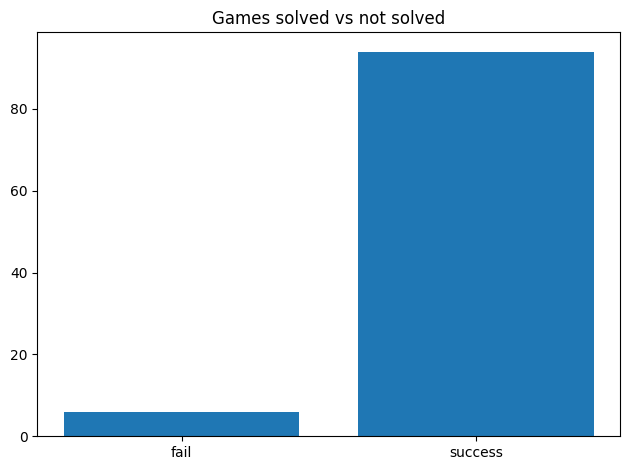

- Success rate: 94.0% (94/100)
- If this is unexpectedly low/high, verify success detection and secret distribution.


In [32]:
plt.figure()
plt.bar(['fail','success'], [(games['success']==0).sum(), (games['success']==1).sum()])
plt.title('Games solved vs not solved')
plt.tight_layout()
plt.show()

sr = float(games['success'].mean()) if len(games) else 0.0
noteworthy([
    f"Success rate: {sr:.1%} ({int((games['success']==1).sum())}/{len(games)})",
    "If this is unexpectedly low/high, verify success detection and secret distribution.",
])


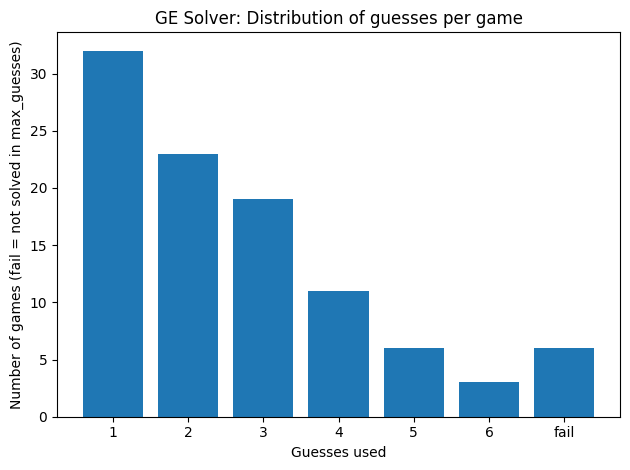

In [33]:
# Count guesses for solved games (1..6) and add a 'fail' bar
solved = games[games["success"] == 1]
unsolved = games[games["success"] == 0]

max_guesses = 6
guess_bins = list(range(1, max_guesses + 1))

counts = solved["num_guesses"].value_counts().reindex(guess_bins, fill_value=0)
fail_count = len(unsolved)

labels = [str(x) for x in guess_bins] + ["fail"]
values = counts.tolist() + [fail_count]

plt.figure()
plt.bar(labels, values)
plt.xlabel("Guesses used")
plt.ylabel("Number of games (fail = not solved in max_guesses)")
plt.title("GE Solver: Distribution of guesses per game")
plt.tight_layout()
plt.show()


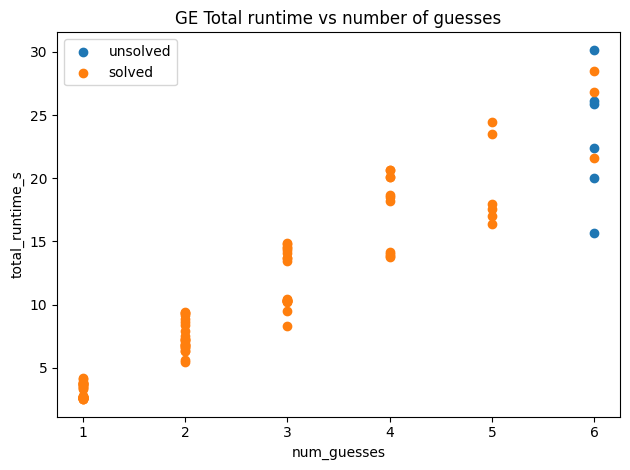

In [34]:
plt.figure()
solved = games[games['success']==1]
unsolved = games[games['success']==0]
plt.scatter(unsolved['num_guesses'], unsolved['total_runtime_s'], label='unsolved')
plt.scatter(solved['num_guesses'], solved['total_runtime_s'], label='solved')
plt.xlabel('num_guesses')
plt.ylabel('total_runtime_s')
plt.legend()
plt.title('GE Total runtime vs number of guesses')
plt.tight_layout()
plt.show()



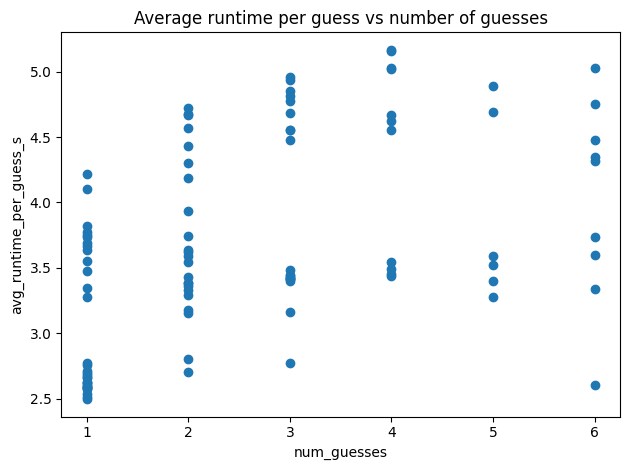

In [35]:
plt.figure()
plt.scatter(games['num_guesses'], games['avg_runtime_per_guess_s'])
plt.xlabel('num_guesses')
plt.ylabel('avg_runtime_per_guess_s')
plt.title('Average runtime per guess vs number of guesses')
plt.tight_layout()
plt.show()



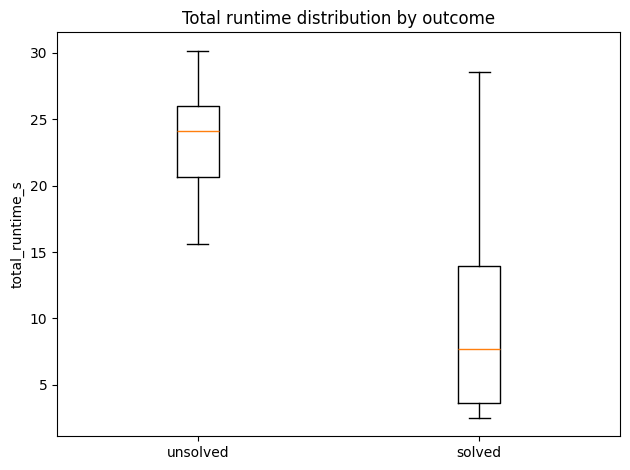

- Median runtime unsolved: 24.15s
- Median runtime solved: 7.68s


In [36]:
plt.figure()
plt.boxplot([
    unsolved['total_runtime_s'].dropna(),
    solved['total_runtime_s'].dropna()
], labels=['unsolved','solved'])
plt.ylabel('total_runtime_s')
plt.title('Total runtime distribution by outcome')
plt.tight_layout()
plt.show()

lines = []
if len(solved) and len(unsolved):
    lines.append(f"Median runtime unsolved: {np.median(unsolved['total_runtime_s']):.2f}s")
    lines.append(f"Median runtime solved: {np.median(solved['total_runtime_s']):.2f}s")
noteworthy(lines or ["Need both solved and unsolved games to compare runtimes."])


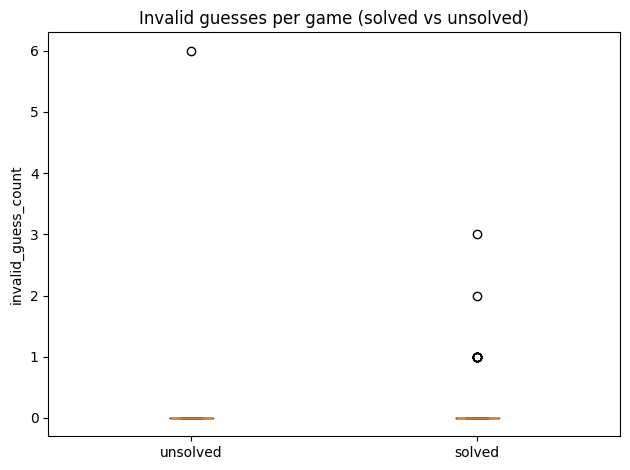

- Games with >=1 invalid guess: 13.0%
- If invalid guesses occur mainly in unsolved games, they may waste turns and reduce feedback.


In [37]:
plt.figure()
plt.boxplot([
    unsolved['invalid_guess_count'].dropna(),
    solved['invalid_guess_count'].dropna()
], labels=['unsolved','solved'])
plt.ylabel('invalid_guess_count')
plt.title('Invalid guesses per game (solved vs unsolved)')
plt.tight_layout()
plt.show()

noteworthy([
    f"Games with >=1 invalid guess: {(games['invalid_guess_count']>0).mean():.1%}",
    "If invalid guesses occur mainly in unsolved games, they may waste turns and reduce feedback.",
])


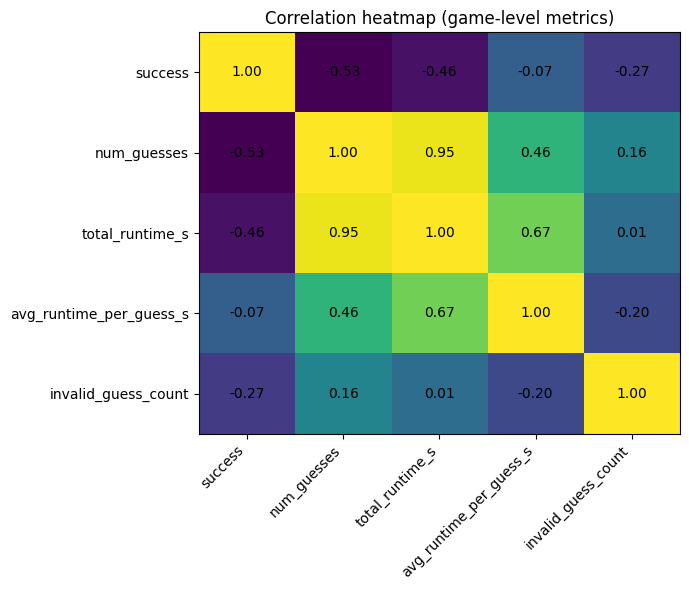

- Strong correlation: num_guesses vs total_runtime_s: r=0.95
- Strong correlation: total_runtime_s vs avg_runtime_per_guess_s: r=0.67
- Strong correlation: success vs num_guesses: r=-0.53


In [38]:
plt.figure(figsize=(7,6))
cols = ['success','num_guesses','total_runtime_s','avg_runtime_per_guess_s','invalid_guess_count']
gm = games[cols].apply(pd.to_numeric, errors='coerce')
corr = gm.corr()
plt.imshow(corr, aspect='auto')
plt.xticks(range(len(cols)), cols, rotation=45, ha='right')
plt.yticks(range(len(cols)), cols)
for i in range(len(cols)):
    for j in range(len(cols)):
        plt.text(j, i, f"{corr.iloc[i,j]:.2f}", ha='center', va='center')
plt.title('Correlation heatmap (game-level metrics)')
plt.tight_layout()
plt.show()

pairs = []
for i,a in enumerate(cols):
    for j,b in enumerate(cols):
        if j<=i: continue
        v = corr.loc[a,b]
        if pd.notna(v):
            pairs.append((abs(v), v, a, b))
pairs.sort(reverse=True)
lines = [f"Strong correlation: {a} vs {b}: r={v:.2f}" for _, v, a, b in pairs[:3]]
noteworthy(lines)


## Guess-level graphs


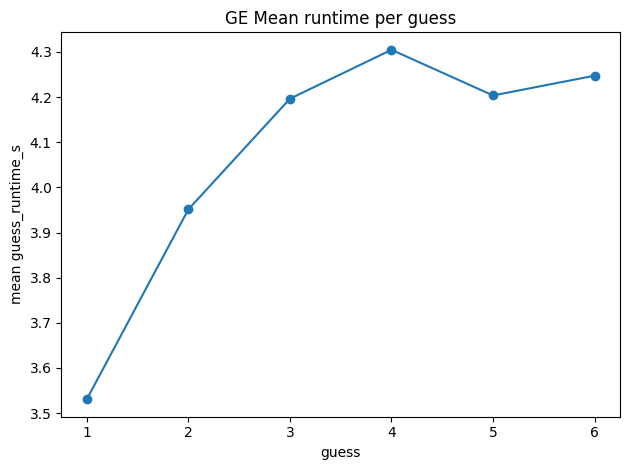

- Fastest avg guess index: 0 (3.53s)
- Slowest avg guess index: 3 (4.30s)


In [39]:
plt.figure()
guess_runtime_mean = guesses.groupby('guess_index')['guess_runtime_s'].mean()
plt.plot(guess_runtime_mean.index+1, guess_runtime_mean.values, marker='o')
plt.xlabel('guess')
plt.ylabel('mean guess_runtime_s')
plt.title('GE Mean runtime per guess')
plt.tight_layout()
plt.show()

lines = []
if len(guess_runtime_mean):
    lines.append(f"Fastest avg guess index: {int(guess_runtime_mean.idxmin())} ({guess_runtime_mean.min():.2f}s)")
    lines.append(f"Slowest avg guess index: {int(guess_runtime_mean.idxmax())} ({guess_runtime_mean.max():.2f}s)")
noteworthy(lines)


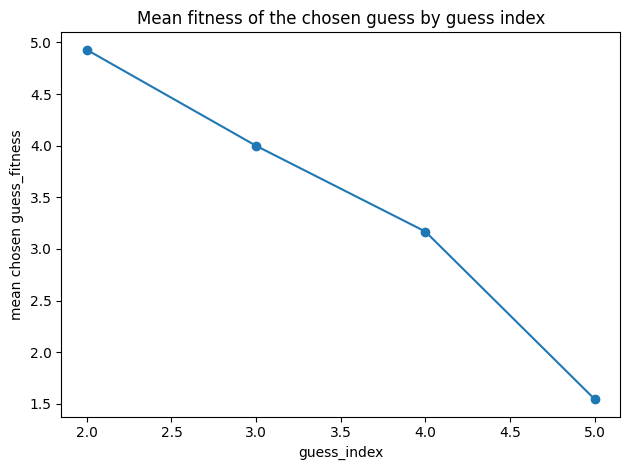

- Mean chosen-fitness change (last-first): inf
- If fitness rises but solve rate stays flat, the objective may be misaligned.


In [40]:
plt.figure()
guess_fit_mean = guesses.groupby('guess_index')['guess_fitness'].mean()
plt.plot(guess_fit_mean.index, guess_fit_mean.values, marker='o')
plt.xlabel('guess_index')
plt.ylabel('mean chosen guess_fitness')
plt.title('Mean fitness of the chosen guess by guess index')
plt.tight_layout()
plt.show()

lines = []
if len(guess_fit_mean) >= 2:
    lines.append(f"Mean chosen-fitness change (last-first): {(guess_fit_mean.iloc[-1]-guess_fit_mean.iloc[0]):.3f}")
lines.append("If fitness rises but solve rate stays flat, the objective may be misaligned.")
noteworthy(lines)


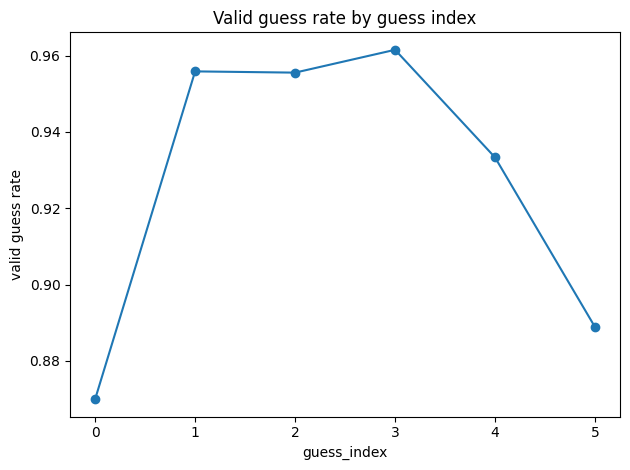

- A valid guess rate near 1.0 means the solver is consistently producing feedback-bearing guesses.
- Drops later often indicate constraints tightening or elites persisting incorrectly.


In [41]:
plt.figure()
valid_rate = guesses.groupby('guess_index')['guess_valid'].mean()
plt.plot(valid_rate.index, valid_rate.values, marker='o')
plt.xlabel('guess_index')
plt.ylabel('valid guess rate')
plt.title('Valid guess rate by guess index')
plt.tight_layout()
plt.show()

noteworthy([
    "A valid guess rate near 1.0 means the solver is consistently producing feedback-bearing guesses.",
    "Drops later often indicate constraints tightening or elites persisting incorrectly.",
])


## Generation-level graphs


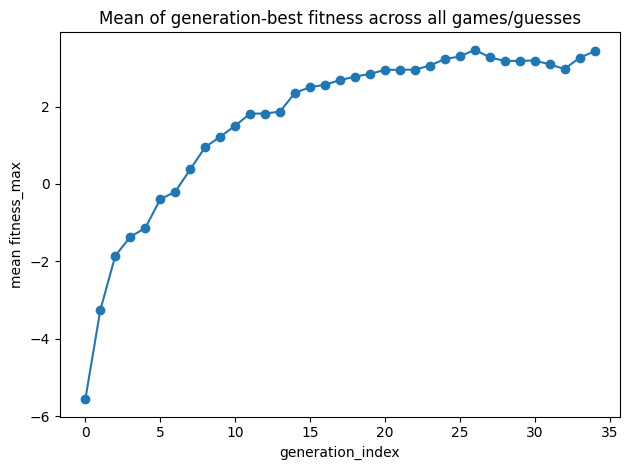

- Avg best-fitness improvement (last-first): 8.984
- A smooth rise indicates effective selection; flat suggests stagnation or many -inf individuals.


In [42]:
plt.figure()
gen_max_curve = (
    gens.replace([np.inf, -np.inf], np.nan)
        .groupby("generation_index")["fitness_max"]
        .mean()
)
plt.plot(gen_max_curve.index, gen_max_curve.values, marker='o')
plt.xlabel('generation_index')
plt.ylabel('mean fitness_max')
plt.title('Mean of generation-best fitness across all games/guesses')
plt.tight_layout()
plt.show()

lines = []
if len(gen_max_curve) >= 2:
    lines.append(f"Avg best-fitness improvement (last-first): {(gen_max_curve.iloc[-1]-gen_max_curve.iloc[0]):.3f}")
lines.append("A smooth rise indicates effective selection; flat suggests stagnation or many -inf individuals.")
noteworthy(lines)


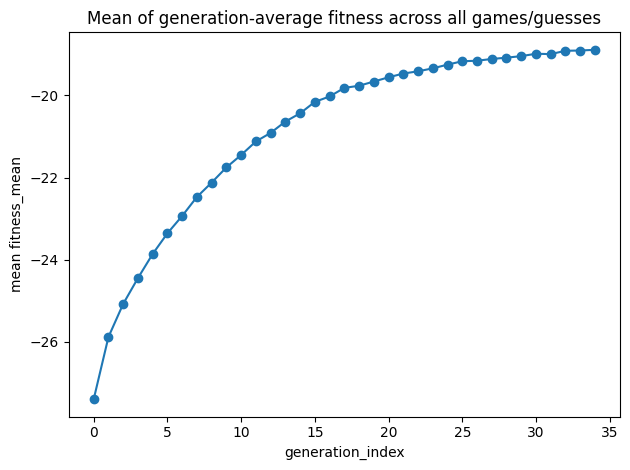

- Avg mean-fitness change (last-first): 8.511
- If mean improves but max does not, population gets generally better without standout candidates.


In [43]:
plt.figure()
gen_mean_curve = (
    gens.replace([np.inf, -np.inf], np.nan)
        .groupby("generation_index")["fitness_mean"]
        .mean()
)
plt.plot(gen_mean_curve.index, gen_mean_curve.values, marker='o')
plt.xlabel('generation_index')
plt.ylabel('mean fitness_mean')
plt.title('Mean of generation-average fitness across all games/guesses')
plt.tight_layout()
plt.show()

lines = []
if len(gen_mean_curve) >= 2:
    lines.append(f"Avg mean-fitness change (last-first): {(gen_mean_curve.iloc[-1]-gen_mean_curve.iloc[0]):.3f}")
lines.append("If mean improves but max does not, population gets generally better without standout candidates.")
noteworthy(lines)


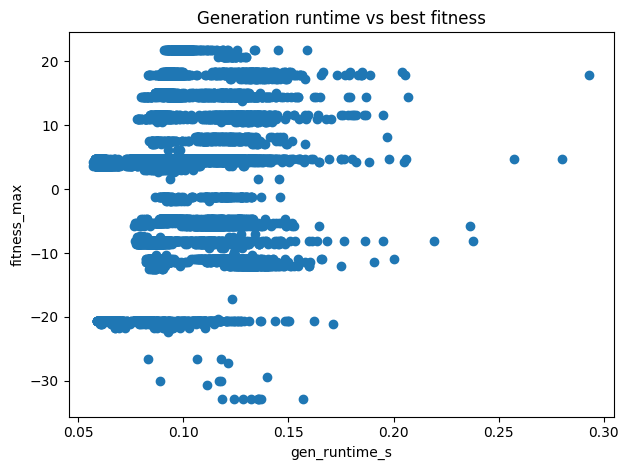

- Correlation(gen_runtime_s, fitness_max): nan
- If longer gens correlate with higher fitness, expensive checks may be paying off; otherwise overhead dominates.


c:\Python312\Lib\site-packages\numpy\lib\function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


In [44]:
plt.figure()
plt.scatter(gens['gen_runtime_s'], gens['fitness_max'])
plt.xlabel('gen_runtime_s')
plt.ylabel('fitness_max')
plt.title('Generation runtime vs best fitness')
plt.tight_layout()
plt.show()

r = corr_pair(gens, 'gen_runtime_s', 'fitness_max')
noteworthy([
    f"Correlation(gen_runtime_s, fitness_max): {r:.3f}",
    "If longer gens correlate with higher fitness, expensive checks may be paying off; otherwise overhead dominates.",
])


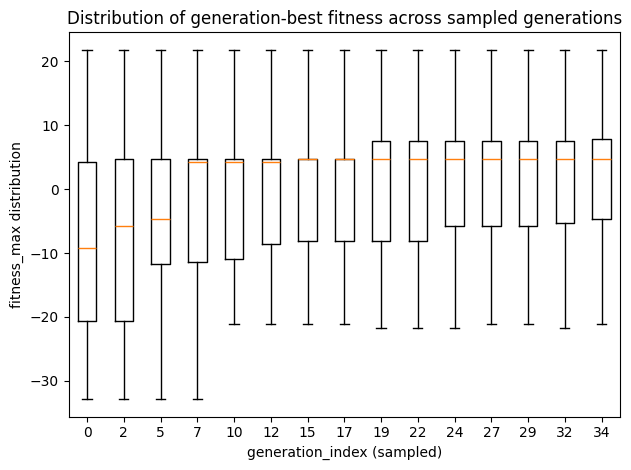

- Boxes tightening over generations indicates convergence.
- Widening or jagged distributions can indicate unstable search or frequent constraint failures.


In [45]:
gen_indices = sorted(gens['generation_index'].unique())
sample = gen_indices if len(gen_indices) <= 15 else np.linspace(min(gen_indices), max(gen_indices), 15).round().astype(int).tolist()
data = [gens.loc[gens['generation_index'] == gi, 'fitness_max'].dropna() for gi in sample]
plt.figure()
plt.boxplot(data, labels=[str(gi) for gi in sample])
plt.xlabel('generation_index (sampled)')
plt.ylabel('fitness_max distribution')
plt.title('Distribution of generation-best fitness across sampled generations')
plt.tight_layout()
plt.show()

noteworthy([
    "Boxes tightening over generations indicates convergence.",
    "Widening or jagged distributions can indicate unstable search or frequent constraint failures.",
])


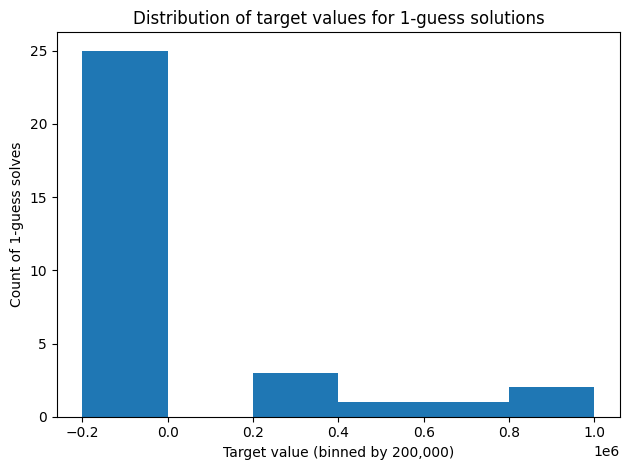

Smallest and largest target values solved in 1 guess:


,game_id,target_value
25,25,-98324.0
30,30,-97945.0
64,64,-96184.0
76,76,-95832.0
41,41,-90599.0


,game_id,target_value
16,16,978957.0
95,95,922213.0
42,42,675100.0
10,10,531961.0
31,31,358374.0


- 1-guess solves: 32 (32.0% of all games)
- Target min/max: -98324 / 978957
- Bins: 6 bins of width 200,000


In [54]:
one_guess = games[(games["success"] == 1) & (games["num_guesses"] == 1)].copy()

if len(one_guess) == 0:
    print("No games solved in 1 guess.")
else:
    vals = one_guess["target_value"].to_numpy()

    bin_width = 200000
    vmin = np.floor(vals.min() / bin_width) * bin_width
    vmax = np.ceil(vals.max() / bin_width) * bin_width
    bins = np.arange(vmin, vmax + bin_width, bin_width)

    plt.figure()
    plt.hist(vals, bins=bins)
    plt.xlabel("Target value (binned by 200,000)")
    plt.ylabel("Count of 1-guess solves")
    plt.title("Distribution of target values for 1-guess solutions")
    plt.tight_layout()
    plt.show()

    print("Smallest and largest target values solved in 1 guess:")
    smallest = one_guess.nsmallest(5, 'target_value')[['game_id','target_value']]
    largest = one_guess.nlargest(5, 'target_value')[['game_id','target_value']]
    display(smallest)
    display(largest)
    noteworthy([
        f"1-guess solves: {len(one_guess)} ({len(one_guess)/len(games):.1%} of all games)",
        f"Target min/max: {vals.min():.0f} / {vals.max():.0f}",
        f"Bins: {int(len(bins)-1)} bins of width {bin_width:,}",
    ])